# El dataset de MNIST

Para este ejemplo usaremos el dataset `MNIST`, que consiste en un conjunto de 70.000 imágenes escaladas a gris y con 10 clasificaciones referidas al tipo de prenda que constituyen. Se trata de la sustitución del dataset tradicional usado para demostrar el uso e implementación de las redes neuronales para la clasificación.

Usaremos 60.000 imágenes para el entrenamiento y 10.000 para la clasificación.

## Importar TensorFlow

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


### Carga de datos
En primer lugar, cargamos el dataset de la librería de `keras`.

In [7]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Esto devuelve cuatro arrays de numpy:
* El `train_images` y `train_labels` que son los datos que usa el modelo para aprender
* Los conjuntos para la validación `test_images` y `test_labels`

Las imágenes son arrays de Numpy de 28x28, con 
valores de pixel entre 0 y 225. Las etiquetas son enteros positivos entre 0 y 9, correspondiendo a las clases a la que corresponde cada etiqueta.

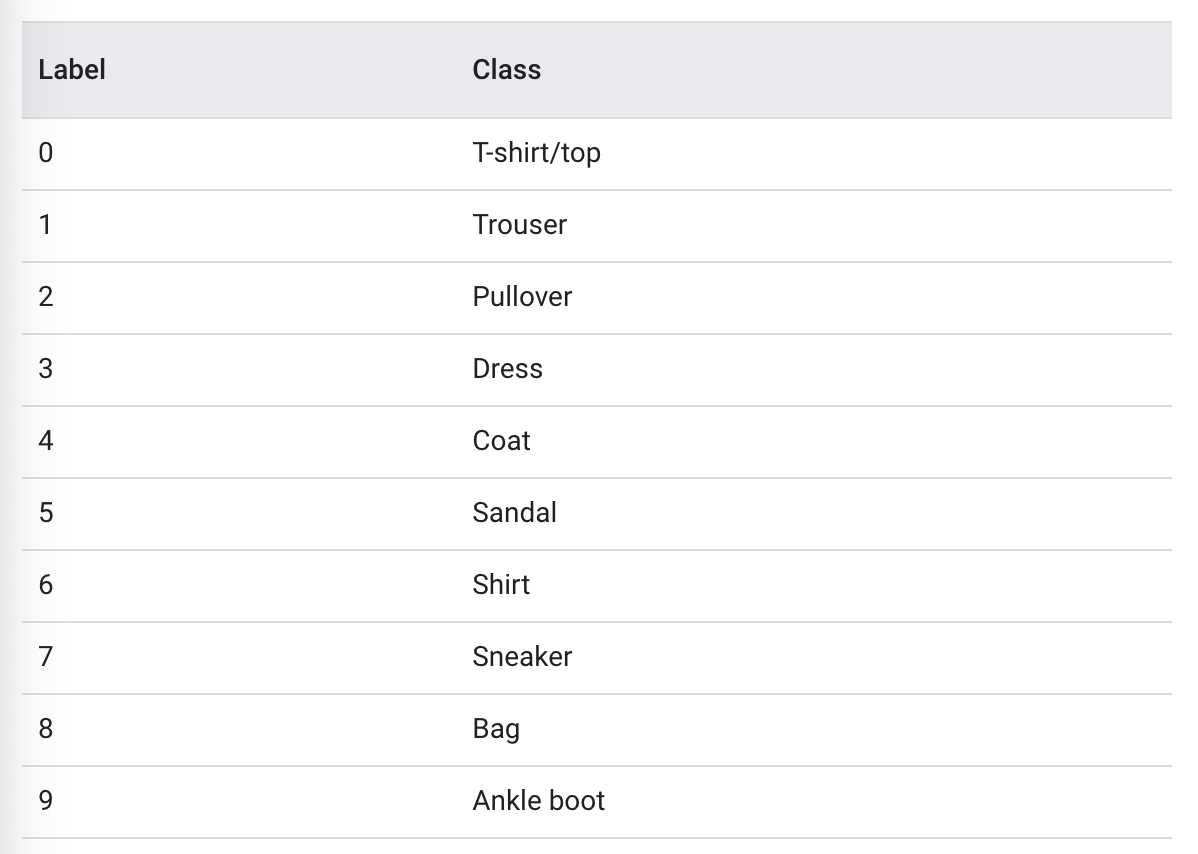

In [2]:
from IPython.display import Image
Image("resources/ropa-labels.png")

Cada imagen es mapeada a una única etiqueta. Añadimos los nombres de las clases ya que estos no vienen por defecto en el dataset.

In [9]:
class_names=['Camiseta/top','Pantalón','Suéter','Vestido','Abrigo','Cholas','Camisa','Tenis','Bolsa/o','Botines']

## Exploración de los datos

Exploraremos los conjuntos de entrenamiento y validación antes de proceder con el modelo. Veremos que el primero está conformado por 60.000 imágenes, cada una de ellas representada con 28x28 pixeles.

In [10]:
train_images.shape

(60000, 28, 28)

De la misma fomra, hay 60.000 etiquetas en el conjunto de entrenamiento.

In [11]:
len(train_labels)

60000

Cada etiqueta es un entero entre 0 y 9.

In [12]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Hay 10.000 imágenes en el set de validación. De nuevo, cada imágen es representada por 28x28 píxeles.

In [13]:
test_images.shape

(10000, 28, 28)

Y el set contiene 10.000 etiquetas de imágen.

In [14]:
len(test_labels)

10000

## Preprocesamiento de los datos

Los datos deben ser preprocesados antes de entrenar a la red. Si inpeccionamos la primera imagen del conjunto de entrenamiento, veremos como los valores de los píxeles caen entre 0 y 255.

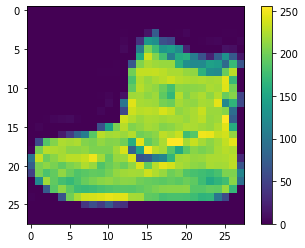

In [16]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

### Normalizar los datos
En primer lugar, tendremos que normalizar la información contenida en los píxeles. Para ello dividimos su valor por 255.

In [17]:
train_images = train_images/255.0
test_images = test_images/255.0

Para verificar que los datos están en el formato adecuado y estamos preparados para entrenar a la red, imprimamos las primeras 25 imágenes del conjunto de entrenamiento y el nombre de su clase bajo cada una de ellas.

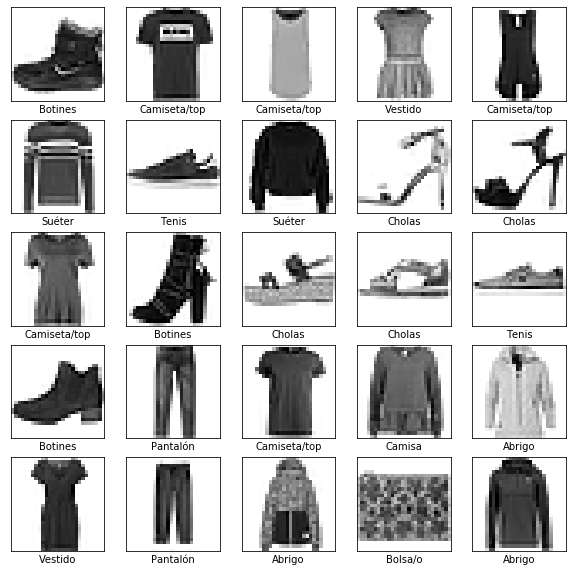

In [19]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Construir el modelo

Construir el modelo implica configurar las capas del mismo y posteriormente compilarlo.

### Preparar las capas

El bloque básico de construcción de una Red Neuronal es la _**capa**_. Las capas extraen representaciones de los datos que les damos de comer. Idealmente, estas representaciones serán significaticas para el problema que tenemos entre manos.

La mayor parte del *Deep Learning* consiste en encadenar capas simples. La mayoría de las capas, como `tf.keras.layers.Dense` tienen parámetros que la red aprende a medida que va entrenando.

In [23]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

La primera capa en esta red, `tf.keras.layers.Flatten` transforma el formato de las imágenes de un arreglo bidimensional de 28x28 a un arreglo unidimensional de `28 x 28 = 784` píxeles. Este es un paso esencial a la hora de trabajar con imágenes y Visión por Ordenador. La forma en la que pensaremos en nuestros datos será en un array de p. ej. 60.000 filas y 784 columnas para el conjunto de entrenamiento, o lo que es lo mismo, un espacio vectorial de 784 dimensiones.

Tras ello, usamos una secuencia de dos capas `tf.keras.layers.Dense`. Estas están conectadas densamente o completamente. La primera capa tiene 128 nodos o neuronas. 

La segunda (y última) consiste en una capa `softmax` de 10 nodos que devuelve un arreglo de 10 puntuaciones posibles que suman 1. Cada nodo contiene una puntuación que indica la probabilidad de que la imagen correspondiente pertenezca a una de las 10 clases. Este es el tipo de capa que se suele situar al final del modelo de RN, ya que es muy sencilla. Lleva a cabo dos simples cálculos:
1. Suma las evidencias de que la entrada de datos sea de cierta clase de cada una de las posibles, y convierte cada una de esas evidencias en probabilidades. Para dar una evidencia de que una imagen pertenece a una clase en particular se pondera la suma de productos de todos y cada uno de los píxeles. Si el peso es negativo, contará en contra.

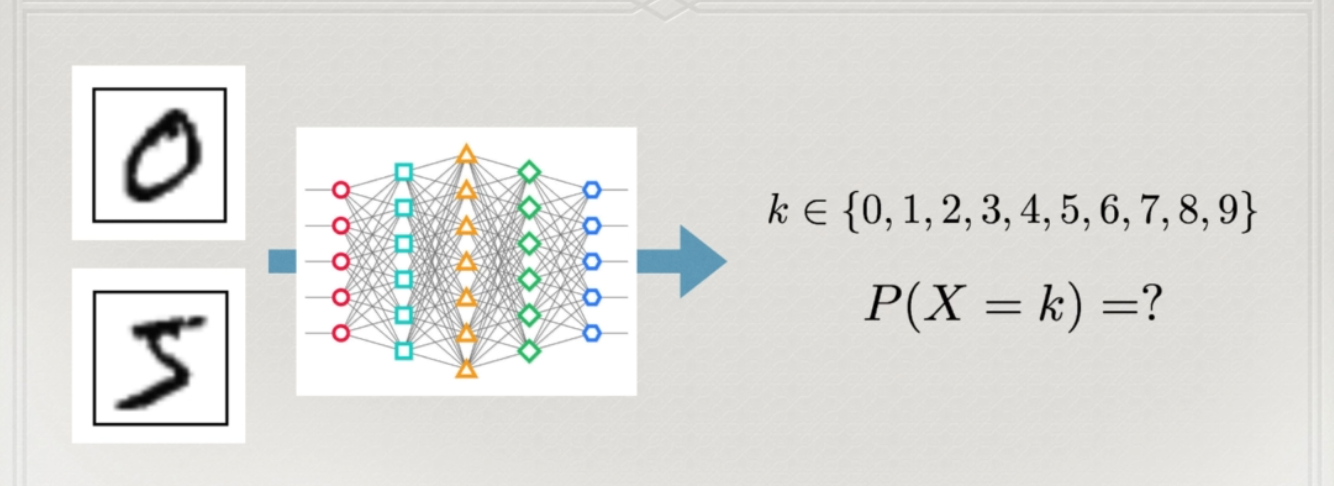

In [3]:
Image("resources/softmax1.png")

En el caso del data set de los números, el peso es negativo si el píxel correspondiente tiene una muy alta intensidad de estar en contra de la imagen para la cual se está clasificando. Por contra, será positivo o tiene alta intensidad si hay evidencias en favor de que la imagen pertenezca a un cierto conjunto. 

Las siguientes imágenes representan los pesos que un modelo ha aprendido de cada una de las clases. Rojo representa que si hay algo ahí pintado tiene que contar en contra. P. ej. si hay algo pintado en el centro en el cero, tiene que ir en contra de que se clasifique como cero. Mientras que el azul representa positivo, y podemos ver en la imagen como las regiones azules aproximan las formas de los números correspondientes a cada clase. La RN irá afinando las puntuaciones o representaciones de cada clase.

Los factores/parámetros adicionales lo que hacen es añadir información para dar un sesgo de información que ayuda a la red a definir las clases. Se corresponde con el parámetro del intercept en una regresión lineal.

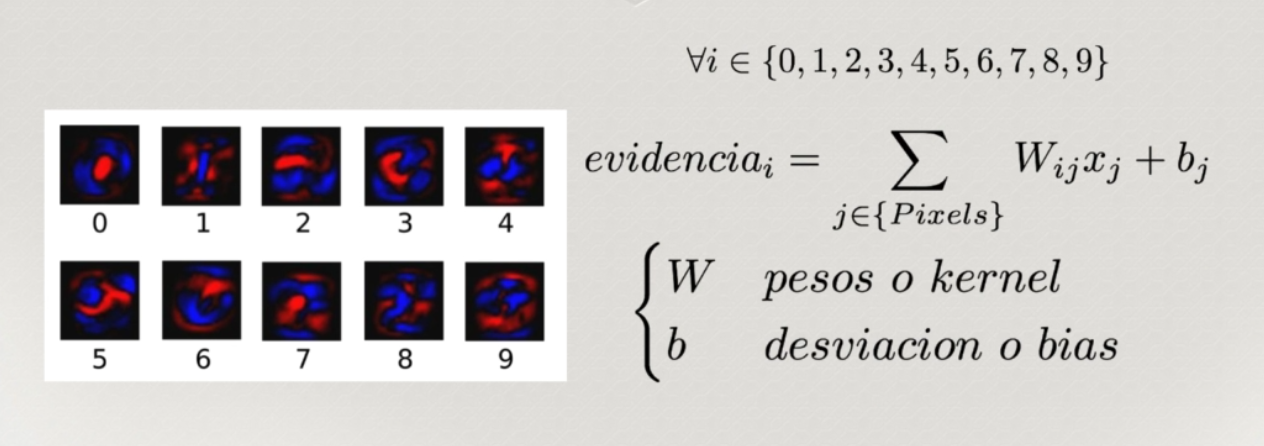

In [4]:
Image("resources/softmax2.png")

La segunda parte del proceso de la regresión softmax consistirá en calcular la evidencia para cada una de las clases contrastando el peso obtenido contra la matriz de pesos de cada clase (i.e. cada número o cada prenda de ropa) hasta haber obtenido 10 valores para las evidencias (uno para cada clase. Estos valores se convertirán en probabilidades a través de la función de `softmax`, que servirá como enlace a la pertenencia a una clase o no.

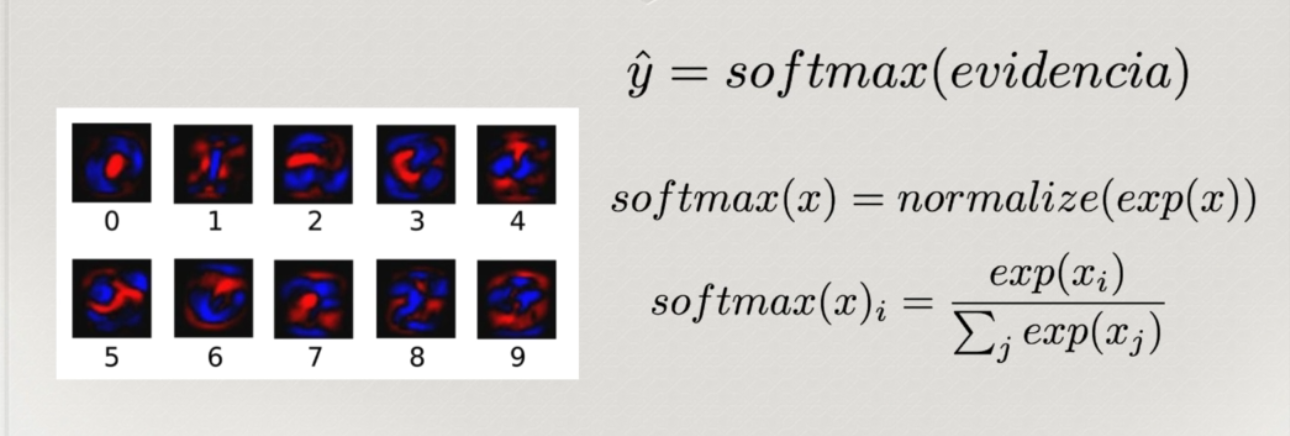

In [5]:
Image("resources/softmax3.png")

La regresión Softmax se puede hacer con distintas funciones. La sigmoide de 10 dimensiones es la más habitual. Lo que se consigue con la aplicación de esta capa es que la suma de los pesos sea 1, representando las probabilidades.

La exponencial lo que hace es elevar `e` a todas y cada una de las entradas y las vamos a normalizar. La exponenciación significa que cuanto más cerca de 1, más contarán para el peso final, mientras que los números pequeños son penalizados por esta función. La conversión no tendría por qué tener valores de 0 a 1, por lo que se normaliza para que se conviertan en probabilidades y así encontrar la mayor de todas ellas.

El siguiente esquema representa los pasos anteriores.

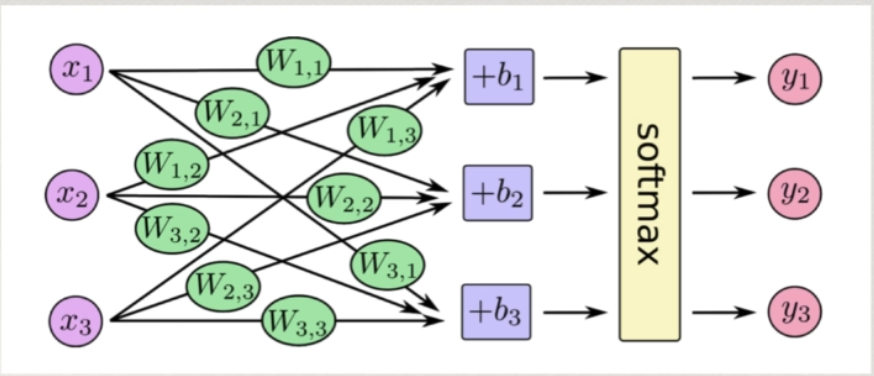

In [6]:
Image('resources/softmax4.png')

O en forma de función.

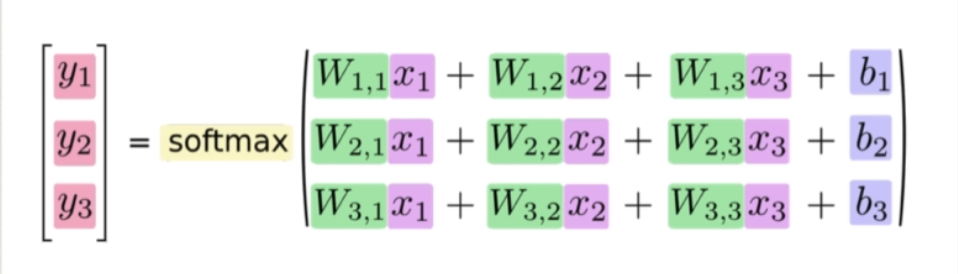

In [7]:
Image("resources/softmax5.png")

Esta operación matricial con sumas dentro se convierte en un producto matricial con una suma de vectores, lo que lo hace mucho más eficiente computacionalmente

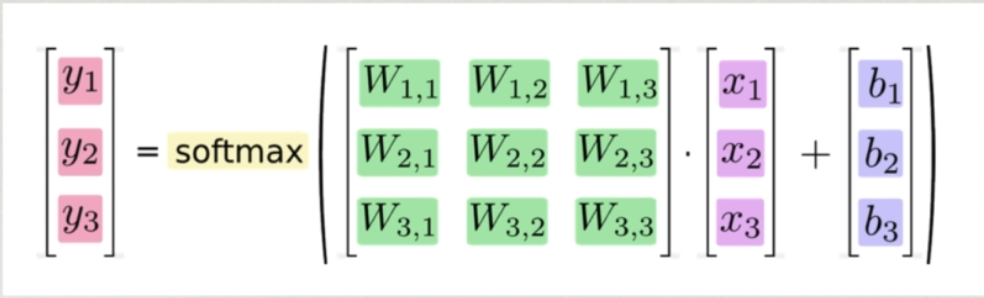

In [8]:
Image("resources/softmax6.png")

Quedando la operación resumida en la siguiente expresión.

$\hat{y} = softmax(W\cdot x + b)$

## Compilar el modelo

Antes de que el modelo esté listo para el entrenamiento necesita una serie de ajustes previos. Estos son los añadidos durante la fase de compilación del modelo.

* **Función de pérdidas** - Esta mide cuán preciso es el modelo durante el entrenamiento. Querremos minimizar esta función para guiar al modelo en la dirección correcta
* **Optimizador** - Este representa como se actualiza el modelo en base a los datos que recibe y a la función de pérdidas
* **Métricas** - Se usan para monitorear los pasos del entrenamiento y la validación. En el ejemplo usaremos la métrica de *precisión* (`accuracy`), el ratio de imagenes correctamente clasificadas.

In [24]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

La eficacia de un modelo de RN actualmente se mide a través del coste o pérdida que produce, que representa lo lejos que está nuestro modelo de la salida que nosotros queremos que nos de. Por tanto, siempre trataremos de minimizar dicho error. El modelo nunca va a ser bueno, siempre va a ser malo, pero intentaremos que sea el menos malo posible.

La forma más común de hacer esta clasificación es determinar la función de pérdidas a través de la **_Entropía Cruzada_**. Esta surge de pensar como se comprimen los códigos en teoría de la información sin sufrir pérdidas. La expresión es la siguiente.

$H_{y'}(\hat{y}) = -\sum_{i}y_i' log(\hat{y_i})$

Donde $\hat{y}$ es la probabilidad de la distribución de nuestra predicción e $y'$ es el valor real.

La entropía cruzada mide como de ineficientes son nuestras predicciones con respecto de describir la realidad. Es una forma de cruzar ambos valores (predicho y real).

## Entrenar el modelo

Entrenar el modelo de Red Neuronal consta de los siguientes pasos:

1. Alimentamos el modelo con datos. En este caso con `train_images` y `train_labels`.
2. El modelo aprende a asociar imágenes y etiquetas
3. Le pedimos al modelo que haga predicciones sobre el conjunto de validación `test_images` y verificamos que estas coincidan con las etiquetas del mismo conjunto `test_labels`.

Para empezar a entrenar el modelo, llamamos al método `model.fit` - llamado así porque ajusta el modelo al conjunto de entrenamiento.

In [25]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.4990 - acc: 0.8251
Epoch 2/10
60000/60000 [==============================] - 5s 77us/sample - loss: 0.3748 - acc: 0.8656
Epoch 3/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.3377 - acc: 0.8776
Epoch 4/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.3126 - acc: 0.88601s - loss:
Epoch 5/10
60000/60000 [==============================] - 6s 102us/sample - loss: 0.2953 - acc: 0.8920
Epoch 6/10
60000/60000 [==============================] - 8s 129us/sample - loss: 0.2797 - acc: 0.8966
Epoch 7/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.2698 - acc: 0.8997
Epoch 8/10
60000/60000 [==============================] - 5s 81us/sample - loss: 0.2589 - acc: 0.90370s - loss: 0.2582 - acc: 0
Epoch 9/10
60000/60000 [==============================] - 5s 77us/sample - loss: 0.2482 - acc: 0.9071
Epoch 10/10
60000/60000 [===================

Según va entrenando el modelo, se van mostrando las métricas de *pérdidas* (loss) y de *precisión*. En concreto, este modelo alcanza una precisión de aproximadamente 0.88 (u 88%) en el conjunto de entrenamiento.

## Evaluar la precisión

A continuación, comparemos el desempeño del modelo sobre el conjunto de validación.

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("\nPrecisión de validación:", test_acc)

10000/10000 [==============================] - 1s 71us/sample - loss: 0.3360 - acc: 0.8840

Precisión de validación: 0.884


Resulta que la precisión en el conjunto de validación es algo inferior a la del conjunto de entrenamiento. Esta diferencia entre las precisiones representa que hay *overfiting*. Este fenómeno se da cuando un modelo de ML tiene un desempeño peor con imágenes nuevas respecto a las que ha usado para entrenar.

## Predicciones

Con el modelo entrenado, podemos usarlo para hacer predicciones sobre nuevas imágenes.

In [27]:
predictions = model.predict(test_images)

El modelo ha predicho la etiqueta para cada imagen en el conjunto de validación. Veamos como se ve una predicción.

In [28]:
predictions[0]

array([1.2305115e-06, 2.7103775e-09, 5.7356262e-09, 4.9536439e-08,
       8.2727185e-09, 7.6982235e-03, 3.9680413e-07, 3.7794720e-02,
       7.9567900e-07, 9.5450455e-01], dtype=float32)

Una predicción es un arreglo de 10 números. Representan la confianza del modelo de que la imagen pertenece a una de las 10 clases diferentes de artículos de moda que tenemos en los datos. Podemos ver qué etiqueta tiene el mayor valor de confianza.

In [29]:
np.argmax(predictions[0])

9

Así que el modelo tiene más confianza en que la imagen se trata de un botín. Si examinamos la etiqueta real de la imagen comprobaremos que la predicción es correcta.

In [30]:
test_labels[0]

9

Realizaremos una representación de un conjunto de 10 predicciones.

In [36]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid('off')
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label=np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label],
                                        color=color))
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label=predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot=plt.bar(range(10), predictions_array, color="#777777")
    predicted_label=np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Echemos un vistazo a la imagen, predicción y arreglo de predicciones de la imagen 0-ésima. Las predicciones correctas se colorean en azul y las incorrectas en rojo. El número da el porcentaje de la etiqueta predicha respecto al total.

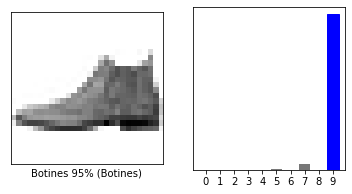

In [37]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

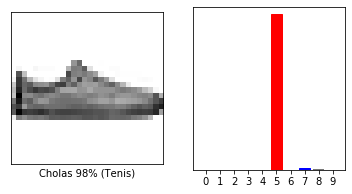

In [38]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], test_labels)
plt.show()

También podemos imprimir varias imágenes y sus correspondientes predicciones para comprobar la eficacia del modelo. Cabe señalar que el modelo puede equivocarse aun obteniendo altos valores de confianza.

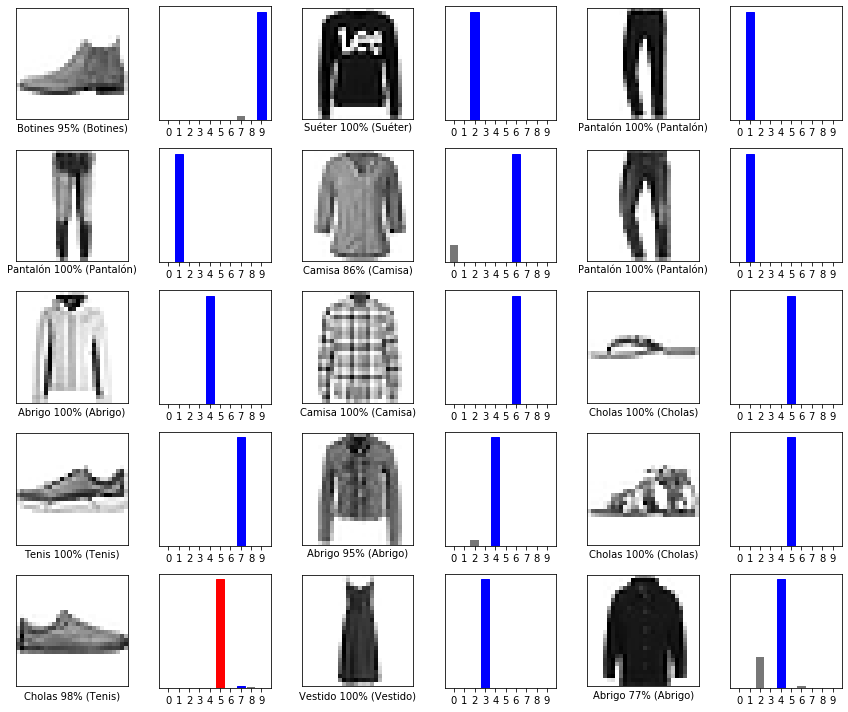

In [40]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Finalmente, usamos el modelo entrenado para hacer una predicción en una sola imagen.

In [44]:
# Tomamos una imagen del dataset
img = test_images[1]
print(img.shape)

(28, 28)


`tf.keras` está optimizado para hacer predicciones sobre conjuntos de datos de una sola vez. Por tanto, será necesario añadir nuestra imagen a una lista para que el modelo la pueda procesar.

In [45]:
img = np.expand_dims(img,0)
print(img.shape)

(1, 28, 28)


Ahora predecimos la etiqueta para esta imagen.

In [46]:
predictions_single = model.predict(img)
print(predictions_single)

[[5.6732461e-06 5.1650139e-13 9.9828869e-01 8.9720775e-10 1.6717750e-03
  1.6022166e-11 3.3743319e-05 1.0617114e-17 2.2238805e-11 4.1875526e-17]]


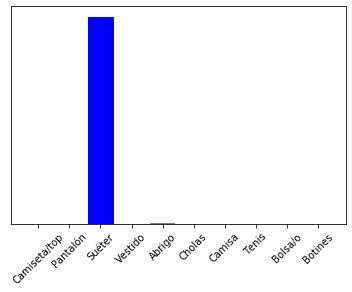

In [47]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` retorna una lista de listas - una lista para cada imagen en el conjunto de datos. Finalmente, tomamos la predicción para nuestra (única) imagen en el conjunto.

In [48]:
np.argmax(predictions_single[0])

2

En este caso, el modelo predice la etiqueta correcta.